## Notebook To Display CO2 Data
Catherine Kuhn , 2018-09-11

## Load Libraries and Data

In [1]:
# start with same libraries as vector tutorial
%matplotlib inline

from __future__ import (absolute_import, division, print_function)
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
from folium.plugins import TimeSliderChoropleth

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

/root/miniconda/envs/vectorenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%run -i load_data.py

## View Data

In [3]:
df = co2_data_table
df.head(5)

,Reference,Site Type,Latitude,Longitude,DateTime,Altitude,Discharge,Stream Slope,Width,Depth,...,Air Temperature,DO,Chl a,CO2,k,k600,CO2 Flux,CO2 Flux.1,Source,geometry
0,"Alin and Richey, 2012",small stream,-10.066,-67.606,20040701,150.0,NaN,NaN,NaN,NaN,...,28.1,NaN,NaN,140.5,NaN,-18.104,1381.28,NaN,"Alin, S.R., and J.E. Richey. 2012. LBA-ECO CD-...",POINT (-67.60599999999999 -10.066)
1,"Alin and Richey, 2012",small stream,-10.066,-67.606,20040701,150.0,NaN,NaN,NaN,NaN,...,28.1,NaN,NaN,140.5,NaN,-18.320,1267.75,NaN,"Alin, S.R., and J.E. Richey. 2012. LBA-ECO CD-...",POINT (-67.60599999999999 -10.066)
2,"Alin and Richey, 2012",small stream,-10.066,-67.606,20040701,150.0,NaN,NaN,NaN,NaN,...,28.1,NaN,NaN,140.5,NaN,-35.512,1449.39,NaN,"Alin, S.R., and J.E. Richey. 2012. LBA-ECO CD-...",POINT (-67.60599999999999 -10.066)
3,"Alin and Richey, 2012",small stream,-10.066,-67.606,20040701,150.0,NaN,NaN,NaN,NaN,...,28.1,NaN,NaN,140.5,NaN,-20.488,1025.55,NaN,"Alin, S.R., and J.E. Richey. 2012. LBA-ECO CD-...",POINT (-67.60599999999999 -10.066)
4,"Alin and Richey, 2012",small stream,-10.066,-67.606,20040701,150.0,NaN,NaN,NaN,NaN,...,28.1,NaN,NaN,140.5,NaN,-22.272,1411.55,NaN,"Alin, S.R., and J.E. Richey. 2012. LBA-ECO CD-...",POINT (-67.60599999999999 -10.066)


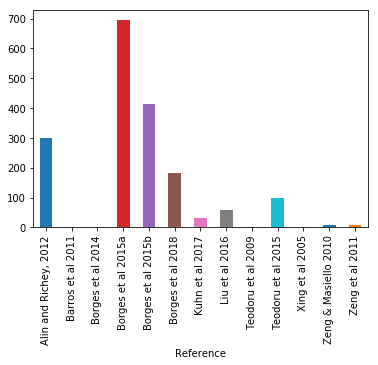

In [4]:
df.groupby(['Reference'])['CO2'].count().plot(kind = 'bar')

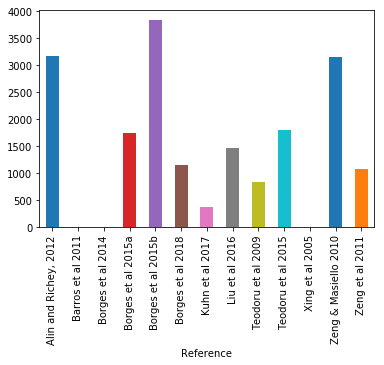

In [5]:
df.groupby(['Reference'])['CO2'].median().plot(kind = 'bar')

In [6]:
#df2 = pd.concat([df['CO2', 'Reference']])

#df2.plot.hist(stacked=True, bins=20)

In [7]:
df.columns

Index(['Reference', 'Site Type', 'Latitude', 'Longitude', 'DateTime',
       'Altitude', 'Discharge', 'Stream Slope', 'Width', 'Depth',
       'Flow Velocity', 'Wind Speed', 'POC', 'DOC', 'TOC', 'pH',
       'Water Temperature', 'Air Temperature', 'DO', 'Chl a', 'CO2', 'k',
       'k600', 'CO2 Flux', 'CO2 Flux.1', 'Source', 'geometry'],
      dtype='object')

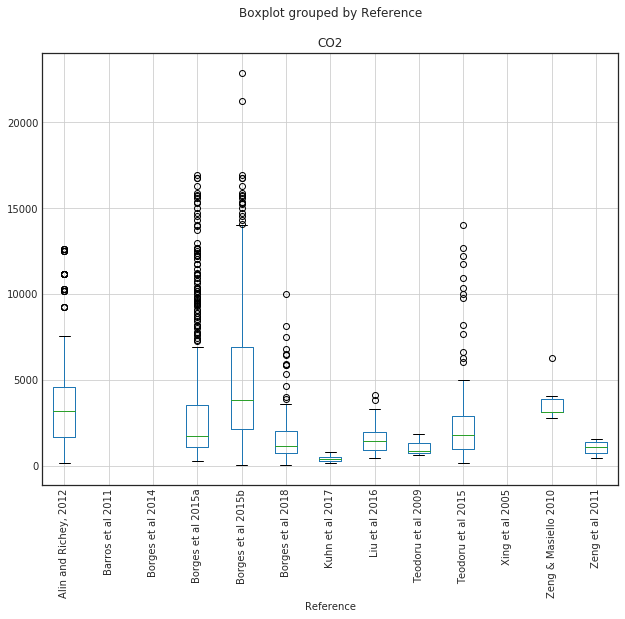

In [8]:
plt.style.use('seaborn-white')

fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
df.boxplot(column=['CO2'], by='Reference', ax=ax)
plt.xticks(rotation=90)
plt.show()

load_data.py:3: RuntimeWarning: divide by zero encountered in log
  # setup script to load data and put into friendly database


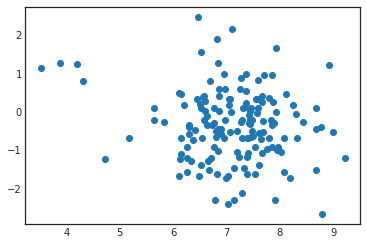

In [9]:
import numpy as np
x = np.log(df['CO2'])
y = np.log(df['Chl a'])
plt.scatter(x, y)

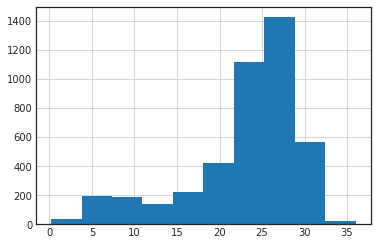

In [10]:
df['Water Temperature'].hist()

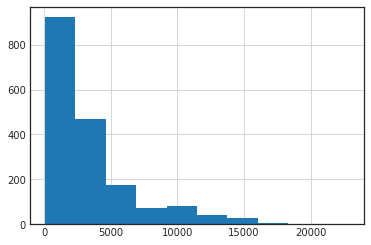

In [11]:
df['CO2'].hist()

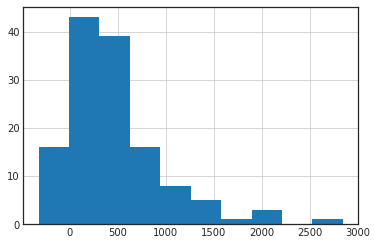

In [12]:
df['CO2 Flux.1'].hist()

Text(0,0.5,'CO2 Flux')

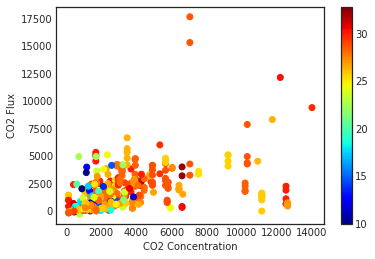

In [13]:
plt.scatter(df.CO2 , df['CO2 Flux'], c=df['Water Temperature'], cmap='jet')

plt.colorbar()

plt.xlabel('CO2 Concentration')
plt.ylabel('CO2 Flux')

## Bring in COSCAT regions

In [14]:
data_pth = "../data/hess_GIS/"

In [52]:
#continenal_shelf = gpd.read_file(os.path.join(data_pth, "Continental_Shelf.shp"))
coscat = gpd.read_file(os.path.join(data_pth, "Continents.shp"))
coscat.head(1)

In [54]:
print(coscat.crs)
print(co2_geo_data_table.crs)

{'init': 'epsg:4326'}
{'init': 'epsg:4326'}


In [67]:
len(coscat['COSCAT'].unique())

231

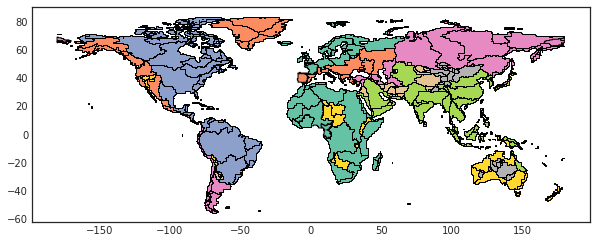

In [68]:
coscat.plot(column='COSCAT', cmap='Set2', categorical=True,  edgecolor='black', figsize=(10, 10));

## Bring in sample points

In [78]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

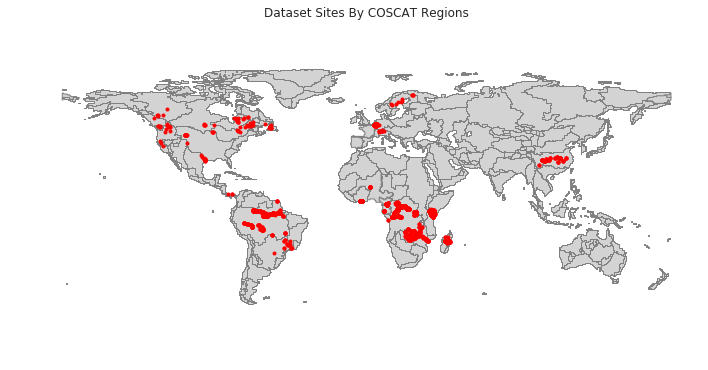

In [80]:
f, ax = plt.subplots(1, figsize=(12, 6))
ax.set_title('Dataset Sites By COSCAT Regions')
coscat.plot(ax=ax, edgecolor='gray', facecolor='lightgrey')
co2_geo_data_table.plot(ax=ax, marker='.', color='r')
ax.set_ylim([-90, 90])
ax.set_axis_off()
plt.axis('equal');

## Do spatial join

In [81]:
samples = gpd.sjoin(co2_geo_data_table, coscat, how="inner")
samples.head(1)

,Reference,Site Type,Latitude,Longitude,DateTime,Altitude,Discharge,Stream Slope,Width,Depth,...,k,k600,CO2 Flux,CO2 Flux.1,Source,geometry,index_right,OBJECTID,COSCAT,MARCATS
0,"Alin and Richey, 2012",small stream,-10.066,-67.606,20040701,150.0,NaN,NaN,NaN,NaN,...,NaN,-18.104,1381.28,NaN,"Alin, S.R., and J.E. Richey. 2012. LBA-ECO CD-...",POINT (-67.60599999999999 -10.066),38,39,1104,7


In [82]:
samples['COSCAT'].unique()

array([1104,  809,  815,  808, 1108,  825,  416,  821,  826,  805,  418,
        818,  830,  403,  405,  817,  834,  807, 1107, 1106,   14,    3,
         17,   15,   16,   11,    8,    9,    7,    6, 1326,  833])

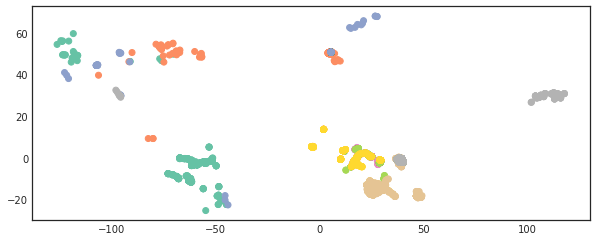

In [86]:
samples.plot(cmap='Set2', categorical = True, figsize=(10, 10));

#samples.plot(column='COSCAT', cmap='Set2', categorical=True,  edgecolor='black', figsize=(10, 10));

In [85]:
samples.groupby(['COSCAT'])['CO2'].mean()

COSCAT
3               NaN
6       1570.414343
7       2920.979167
8       1735.521739
9       1458.250000
11      2692.534483
14      5515.609127
15              NaN
16              NaN
17              NaN
403     1684.397790
405             NaN
416             NaN
418             NaN
805             NaN
807             NaN
808             NaN
809             NaN
815             NaN
817             NaN
818     1104.600000
821             NaN
825             NaN
826             NaN
830             NaN
833     1349.571429
834     1003.694444
1104    3683.515351
1106            NaN
1107            NaN
1108            NaN
1326    1585.728814
Name: CO2, dtype: float64